In [11]:
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from w2v import train_word2vec 
import pickle, datetime
import difflib

import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers
from keras.preprocessing import sequence
from keras import backend as K

np.random.seed(0)

In [13]:
df = pd.read_csv('../../Datasets/SST1_dataset/Processed_SST1.tsv', sep='\t')
train_df = pd.read_csv('../../Datasets/Kaggle_dataset/train.tsv', sep='\t', header=0)
test_df = pd.read_csv('../../Datasets/Kaggle_dataset/test.tsv', sep='\t', header=0)

# raw_docs_train      = df[df.split_ind == 1]['Phrases'].values
# sentiment_train     = df[df.split_ind == 1]['Label'].values
raw_docs_train      = train_df['Phrase'].values
sentiment_train     = train_df['Sentiment'].values
# raw_docs_test       = df[df.split_ind == 2]['Phrases'].values
test_df = pd.read_csv('../../Datasets/Kaggle_dataset/test.tsv', sep='\t', header=0)
sentiment_test      = df[df.split_ind == 2]['Label'].values
num_labels          = len(np.unique(sentiment_train))

N_TRAIN = len(raw_docs_train)
N_TEST = len(raw_docs_test)

In [14]:
#text pre-processing
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
stemmer = SnowballStemmer('english')

print ("pre-processing train docs...")
processed_docs_train = []
for doc in raw_docs_train:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_train.append(stemmed)

print ("pre-processing test docs...")
processed_docs_test = []
for doc in raw_docs_test:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_test.append(stemmed)
    
processed_docs_all = np.concatenate((processed_docs_train, processed_docs_test), axis=0)

dictionary = corpora.Dictionary(processed_docs_all)
dictionary_size = len(dictionary.keys())

print ("converting to token ids...")
word_id_train, word_id_len = [], []
for doc in processed_docs_train:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_train.append(word_ids)
    word_id_len.append(len(word_ids))

word_id_test, word_ids = [], []
for doc in processed_docs_test:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_test.append(word_ids)
    word_id_len.append(len(word_ids))
        
seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

#pad sequences
x_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
x_test  = sequence.pad_sequences(np.array(word_id_test), maxlen=seq_len)
y_train = np_utils.to_categorical(sentiment_train, num_labels)
y_test  = np_utils.to_categorical(sentiment_test, num_labels)

pre-processing train docs...
pre-processing test docs...
converting to token ids...


In [15]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(156060, 12) (2210, 12) (156060, 5) (2210, 5)


# -------------------------------- Training model  -----------------------------------

### Model Paremeters

In [16]:
model_type    = 'CNN-rand'  # CNN-rand|CNN-non-static|CNN-static
embedding_dim = 300         # word2vec dim
vocab_size    = dictionary_size
max_sent_len  = seq_len
N_CATEGORY    = 5

### Generate word2vec 

In [17]:
if model_type in ['CNN-non-static', 'CNN-static']:
    embedding_wts = train_word2vec( np.vstack((x_train, x_test)), 
                                    ind_to_wrd, num_features = embedding_dim)
    if model_type == 'CNN-static':
        x_train = embedding_wts[0][x_train]
        x_test  = embedding_wts[0][x_test]
#         x_valid = embedding_wts[0][x_valid]
        
elif model_type == 'CNN-rand':
    embedding_wts = None
    
else:
    raise ValueError("Unknown model type")

### Create model

In [18]:
batch_size   = 50
filter_sizes = [3,4,5]
num_filters  = 100
dropout_prob = (0.5, 0.8)
hidden_dims  = 100

# Deciding dimension of input based on the model
input_shape = (max_sent_len, embedding_dim) if model_type == "CNN-static" else (max_sent_len,)
model_input = Input(shape = input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, name="embedding", trainable=True)(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolution layers
z1 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[0], 
                padding="valid", activation="relu", 
                strides=1)(z)
z1 = MaxPooling1D(pool_size =2)(z1)
z1 = Flatten()(z1)

z2 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[1], 
                padding="valid", activation="relu", 
                strides=1)(z)
z2 = MaxPooling1D(pool_size=2)(z2)
z2 = Flatten()(z2)

z3 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[2], 
                padding="valid", activation="relu",
                strides=1)(z)
z3 = MaxPooling1D(pool_size=2)(z3)
z3 = Flatten()(z3)

# Concatenate the output of all convolution layers
z = Concatenate()([z1, z2, z3])
z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(N_CATEGORY, activation="softmax")(z)
    
model = Model(model_input, model_output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 12)            0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 12, 300)       3956700                                      
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 12, 300)       0                                            
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 10, 100)       90100                                        
___________________________________________________________________________________________

### Train model 

In [21]:
from sklearn.metrics import roc_auc_score
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        pl.plot(self.acc)
        pl.plot(self.loss)
        pl.plot(self.val_acc)
        pl.plot(self.val_loss)
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_wts)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])

histories = Histories()
res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=50,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

Train on 156060 samples, validate on 2210 samples
Epoch 1/50


In [12]:
import os
os.system('say done')

256

### Computing Accuracy

In [10]:
# Final evaluation of the model
scores = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)

print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 63.96%
Test Accuracy: 36.43%


### Save the model

In [34]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/newtrain_' + model_type + '_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

### Plot the results

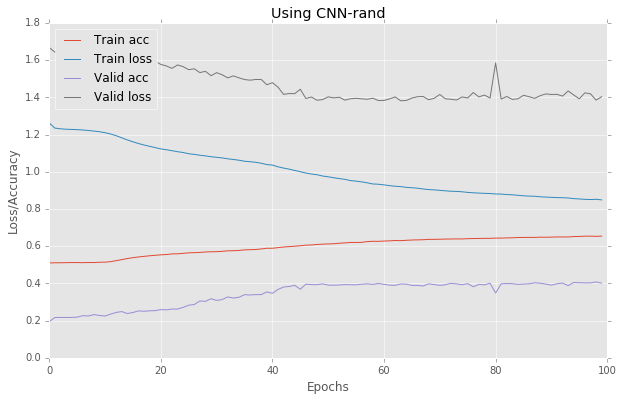

In [46]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

### Continue from a pretrained model

In [47]:
# Loading saved data
import pickle

# filename = '/home/shikhar/Datasets/Models/3_CNN-static_2017-04-04_11:38:41'
with open( filename, 'rb') as input:
    out = pickle.load(input)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(0.005), metrics=["accuracy"])
# model = Model.from_config(out[0])
model.set_weights(out[1])
model.history.history = out[2]

AttributeError: 'Model' object has no attribute 'history'

In [38]:
res = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs=300,
          validation_data=(x_test, y_test), verbose=2)

Train on 156060 samples, validate on 2210 samples
Epoch 1/300
27s - loss: 0.8415 - acc: 0.6568 - val_loss: 1.4342 - val_acc: 0.4005
Epoch 2/300
27s - loss: 0.8416 - acc: 0.6565 - val_loss: 1.4266 - val_acc: 0.4005
Epoch 3/300
24s - loss: 0.8389 - acc: 0.6578 - val_loss: 1.4288 - val_acc: 0.4014
Epoch 4/300
26s - loss: 0.8403 - acc: 0.6564 - val_loss: 1.4244 - val_acc: 0.4041
Epoch 5/300
25s - loss: 0.8391 - acc: 0.6589 - val_loss: 1.4318 - val_acc: 0.4009
Epoch 6/300
25s - loss: 0.8393 - acc: 0.6585 - val_loss: 1.4242 - val_acc: 0.4023
Epoch 7/300
25s - loss: 0.8373 - acc: 0.6582 - val_loss: 1.4232 - val_acc: 0.4023
Epoch 8/300
25s - loss: 0.8398 - acc: 0.6571 - val_loss: 1.4261 - val_acc: 0.3986
Epoch 9/300
25s - loss: 0.8365 - acc: 0.6595 - val_loss: 1.4225 - val_acc: 0.4014
Epoch 10/300
26s - loss: 0.8355 - acc: 0.6593 - val_loss: 1.4259 - val_acc: 0.4063
Epoch 11/300
30s - loss: 0.8350 - acc: 0.6591 - val_loss: 1.4273 - val_acc: 0.4072
Epoch 12/300
26s - loss: 0.8342 - acc: 0.6587 

25s - loss: 0.7973 - acc: 0.6723 - val_loss: 1.4827 - val_acc: 0.4059
Epoch 101/300
26s - loss: 0.7952 - acc: 0.6723 - val_loss: 1.5040 - val_acc: 0.3977
Epoch 102/300
25s - loss: 0.7958 - acc: 0.6730 - val_loss: 1.4860 - val_acc: 0.4081
Epoch 103/300
26s - loss: 0.7962 - acc: 0.6732 - val_loss: 1.4796 - val_acc: 0.4050
Epoch 104/300
25s - loss: 0.7955 - acc: 0.6733 - val_loss: 1.4791 - val_acc: 0.4036
Epoch 105/300
26s - loss: 0.7950 - acc: 0.6719 - val_loss: 1.4881 - val_acc: 0.4041
Epoch 106/300
25s - loss: 0.7953 - acc: 0.6737 - val_loss: 1.4834 - val_acc: 0.4036
Epoch 107/300
25s - loss: 0.7961 - acc: 0.6726 - val_loss: 1.5021 - val_acc: 0.4009
Epoch 108/300
26s - loss: 0.7970 - acc: 0.6728 - val_loss: 1.4832 - val_acc: 0.4050
Epoch 109/300
25s - loss: 0.7938 - acc: 0.6725 - val_loss: 1.4773 - val_acc: 0.4032
Epoch 110/300
26s - loss: 0.7922 - acc: 0.6729 - val_loss: 1.4872 - val_acc: 0.4072
Epoch 111/300
25s - loss: 0.7940 - acc: 0.6734 - val_loss: 1.4862 - val_acc: 0.4041
Epoch 

25s - loss: 0.7700 - acc: 0.6823 - val_loss: 1.5298 - val_acc: 0.4068
Epoch 199/300
25s - loss: 0.7699 - acc: 0.6818 - val_loss: 1.5220 - val_acc: 0.4059
Epoch 200/300
28s - loss: 0.7706 - acc: 0.6818 - val_loss: 1.5198 - val_acc: 0.4041
Epoch 201/300
25s - loss: 0.7707 - acc: 0.6814 - val_loss: 1.5121 - val_acc: 0.4095
Epoch 202/300
26s - loss: 0.7696 - acc: 0.6811 - val_loss: 1.5066 - val_acc: 0.4041
Epoch 203/300
25s - loss: 0.7701 - acc: 0.6824 - val_loss: 1.5280 - val_acc: 0.4023
Epoch 204/300
26s - loss: 0.7692 - acc: 0.6821 - val_loss: 1.5235 - val_acc: 0.4063
Epoch 205/300
25s - loss: 0.7692 - acc: 0.6818 - val_loss: 1.5161 - val_acc: 0.4018
Epoch 206/300
26s - loss: 0.7695 - acc: 0.6826 - val_loss: 1.5344 - val_acc: 0.4000
Epoch 207/300
25s - loss: 0.7675 - acc: 0.6835 - val_loss: 1.5290 - val_acc: 0.4041
Epoch 208/300
25s - loss: 0.7690 - acc: 0.6813 - val_loss: 1.4886 - val_acc: 0.4131
Epoch 209/300
26s - loss: 0.7689 - acc: 0.6828 - val_loss: 1.5284 - val_acc: 0.4027
Epoch 

KeyboardInterrupt: 

### Save the model (marking as continued)

In [24]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/' + model_type + '_continued_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

In [23]:
import os
os.system('say done')

256

In [24]:
files = [
    'CNN-rand_continued_2017-04-02_19:26:35',
    'CNN-rand_continued_2017-04-03_16:50:47',
    'CNN-rand_continued_2017-04-03_17:18:47'
]

In [25]:
train_acc, train_loss, val_acc, val_loss = [],[],[],[]

for file in files:
    filename = '/home/shikhar/Datasets/Models/'  + file
    with open( filename, 'rb') as input:
        out = pickle.load(input)
    train_acc += out[2]['acc']
    train_loss += out[2]['loss']
    val_acc += out[2]['val_acc']
    val_loss += out[2]['val_loss']

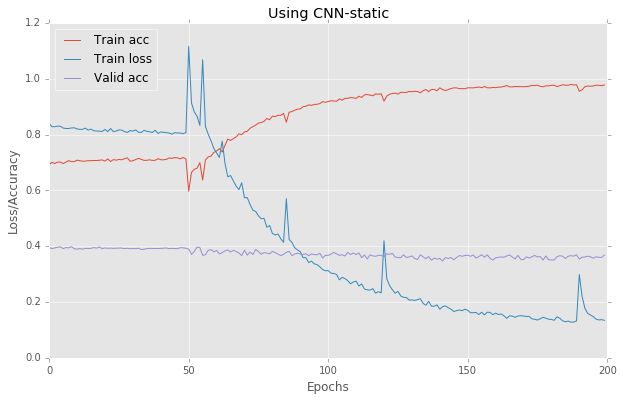

In [35]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
# plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()